## Determine The Solar Angle of DCM and Machine Images

This notebook calculates the solar angle of field images at the moment they were taken.

The solar angle angle is calculated from the timestamps, adjusted to the local time zone, latitude and longitude.

In [3]:
# Import libraries and query Aletheia
# You may need to install some of these libraries

import time
import numpy as np
import pandas as pd
from datetime import datetime as dt
from timezonefinder import TimezoneFinderL
import pytz
from pysolar.solar import *
from brtdevkit.core.db import DBConnector, DatetimeFilter
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.size'] = 18 # Set global font size for plots
%matplotlib inline

def get_shasta_data(filters={}, start=None, end=None, limit=None):
    """
    Query relevant Shasta data for calculations. Written by Andrei P.
    """
    start_time = time.time()
    connector = DBConnector()
    img_filters = {'project_name': 'shasta', **filters}
    if start is not None or end is not None:
        img_filters = [img_filters, DatetimeFilter(key="collected_on", start=start, end=end)]
    df = connector.get_documents_df('image', img_filters, limit=limit)
    elapsed_time = time.time() - start_time
    return df, elapsed_time

# Set filters 
filters = {"artifacts.kind": "nrg", 
           "crop_name": {"$in": ['CORN', 'COTTON', 'SOYBEANS']}, 
           "robot_name": {"$in": ["DCM-MANATEE","DCM-OTTER", "DCM-DOLPHIN", "DCM-WALRUS", "DCM-PORPOISE", "DCM-SEAL"]} }

start = dt(2020, 3,7)

df, elapsed_time = get_shasta_data(filters=filters, start=start)
df['date_collected'] = pd.to_datetime(df['collected_on'].dt.date)
print(f"Queried {len(df)} images in {elapsed_time:.2f} s.")

Queried 283077 images in 268.50 s.


In [4]:
# Find timezones for each image

tf = TimezoneFinderL() # Instantiate TimezoneFinder Light

timestamp = df['collected_on'].tolist()
features = [d.get('coordinates') for d in df.gnss] # Extract GPS coordinates
lat = [features[i][1] for i in range(len(features))]
lng = [features[i][0] for i in range(len(features))]
tz = [tf.timezone_at(lat=lat[i], lng=lng[i]) for i in range(len(features))] # Get Timezones

# Create Dataframe of Relevant Features
tzs = pd.DataFrame({'_id':df.index, 'lng':lng,'lat':lat, 'timestamp':timestamp, 'tz':tz})
tzs['timestamp'] = pd.to_datetime(tzs['timestamp'])
tzs.set_index('timestamp', inplace=True) # Set DateTimeIndex
tzs.index = tzs.index.tz_localize('UTC')# Make DatTimeIndex Timezone Aware
tzs = tzs.dropna()

# At this point there is a DateTimeIndex that is 'utc' localized and timezone aware
print(f'The unique timezones of this dataset are: \n{tzs.tz.unique()}.')

# Proportions of Different timezones
east = tzs[tzs['tz'].isin(['America/New_York','America/Indiana/Vincennes','America/Indiana/Indianapolis'  ])]
cent = tzs[tzs['tz'].isin(['America/Chicago' ,'America/Matamoros', 'America/Winnipeg'])]
west = tzs[tzs['tz'].isin(['America/Denver'])]

print(f'{(len(east)/len(tzs))*100:.1f}% of images were collected in the US-Eastern time zone')
print(f'{(len(cent)/len(tzs))*100:.1f}% of images were collected in the US-Central time zone')
print(f'{(len(west)/len(tzs))*100:.1f}% of images were collected in the US-Western time zone')

The unique timezones of this dataset are: 
['America/Chicago' 'America/Matamoros' 'America/Indiana/Vincennes'
 'America/New_York' 'America/Denver' 'America/Indiana/Indianapolis'
 'America/Winnipeg'].
16.0% of images were collected in the US-Eastern time zone
82.0% of images were collected in the US-Central time zone
2.0% of images were collected in the US-Western time zone


In [5]:
# Adjust timestamps to a timezone-aware local time
# The timestamps are encoded in the field as 'utc' time and must be adjusted to the local timezone.

tzaware = []
for i in range(len(tzs)):
    l = pytz.timezone(tzs['tz'][i]) # create timezone object
    m = tzs.index[i].astimezone(l) # adjust from utc to local time zone
    tzaware.append(m)

In [6]:
# This cell may take 1-2 minutes to run
# Calculate Solar Altitude (angle of sun to horizon)

altitude = np.empty(len(tzs))
for i in range(0,len(tzs)):
    altitude[i] = get_altitude(tzs['lat'][i], tzs['lng'][i] , tzaware[i])

/home/williamroberts/code/brtdevkit/venv/lib/python3.6/site-packages/pysolar/solartime.py:112: UserWarning: I don't know about leap seconds after 2018
  (leap_seconds_base_year + len(leap_seconds_adjustments) - 1)


In [10]:
# add to tzs DataFrame. The tzs dataframe now has a solar angle for every image_id
tzs = pd.concat([tzs, pd.Series(altitude, index =tzs.index, name='solar_angle')], axis =1)
tzs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 282477 entries, 2020-03-25 21:12:40.655000+00:00 to 2020-07-02 18:16:40.861000+00:00
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   _id          282477 non-null  object 
 1   lng          282477 non-null  float64
 2   lat          282477 non-null  float64
 3   tz           282477 non-null  object 
 4   0            282477 non-null  float64
 5   0            282477 non-null  float64
 6   solar_angle  282477 non-null  float64
dtypes: float64(5), object(2)
memory usage: 27.2+ MB


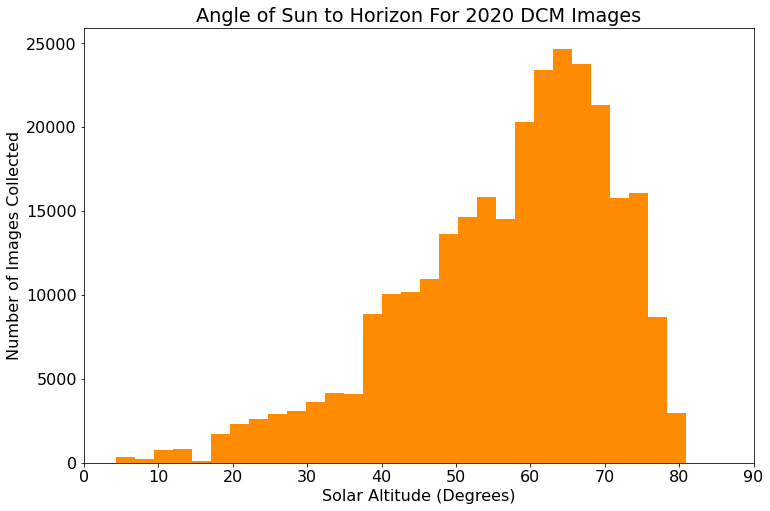

In [8]:
# Plot a nicely formatted histogram of all solar angles
rcParams['font.size']=16

plt.figure(figsize=(12,8))
plt.hist(altitude, bins=30, color='darkorange')
plt.title('Angle of Sun to Horizon For 2020 DCM Images')
plt.ylabel('Number of Images Collected')
plt.xlim(0,90)
plt.xlabel('Solar Altitude (Degrees)')
plt.savefig('Solar_Angle.png')
plt.show()

KeyError: "None of ['_id'] are in the columns"